<a href="https://colab.research.google.com/github/owoMarciN/Python/blob/main/Intro-AI/FinalProject/Intro_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install lion-pytorch
!pip install torchvision
!pip install torch_optimizer
!pip install --upgrade ucimlrepo
!pip install optuna
!pip install xgboost
!pip install -U scikit-fuzzy


In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch_optimizer as toptim

In [ ]:
# SciKit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
import itertools
import random
import optuna

from lion_pytorch import Lion
from torch.utils.data import DataLoader, TensorDataset
from optuna.samplers import TPESampler, NSGAIISampler, GridSampler, RandomSampler
from optuna.pruners import HyperbandPruner

In [ ]:
# Ploting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from ucimlrepo import fetch_ucirepo, list_available_datasets

# check which datasets can be imported
#list_available_datasets()

# import dataset
park = fetch_ucirepo(id=174)

# access data
X = park.data.features
y = park.data.targets
# train model e.g. sklearn.linear_model.LinearRegression().fit(X, y)

# access metadata
# print(park.metadata.uci_id)
# print(park.metadata.num_instances)
# print(park.metadata.additional_info.summary)

# access variable info in tabular format
# print(park.variables)

In [ ]:
# Checking the data

print(X.describe())
feature_names = X.columns.values
print(feature_names)

          MDVP:Fo    MDVP:Fhi    MDVP:Flo  MDVP:Jitter  MDVP:Jitter  \
count  195.000000  195.000000  195.000000   195.000000   195.000000   
mean   154.228641  197.104918  116.324631     0.006220     0.006220   
std     41.390065   91.491548   43.521413     0.004848     0.004848   
min     88.333000  102.145000   65.476000     0.001680     0.001680   
25%    117.572000  134.862500   84.291000     0.003460     0.003460   
50%    148.790000  175.829000  104.315000     0.004940     0.004940   
75%    182.769000  224.205500  140.018500     0.007365     0.007365   
max    260.105000  592.030000  239.170000     0.033160     0.033160   

         MDVP:RAP    MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer  ...  \
count  195.000000  195.000000  195.000000    195.000000    195.000000  ...   
mean     0.003306    0.003446    0.009920      0.029709      0.029709  ...   
std      0.002968    0.002759    0.008903      0.018857      0.018857  ...   
min      0.000680    0.000920    0.002040      0

--------------------------------------------------------------------------------
##Creating a **Countplot** of the dataset features.
--------------------------------------------------------------------------------

In [ ]:
# Class distribution plot

sns.countplot(x=y['status'])
plt.title("Class distribution")
plt.xlabel("Classes (0 - Healthy, 1 - Parkinson)")
plt.ylabel("Count")
plt.show()

--------------------------------------------------------------------------------
##Creating a **Pairplot** of the dataset.
--------------------------------------------------------------------------------

In [ ]:
pp_data = X[['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:RAP', 'MDVP:PPQ']]

sns.pairplot(pp_data)
plt.show()

--------------------------------------------------------------------------------
##Creating a **Correlation HeatMap** of the dataset.
--------------------------------------------------------------------------------

In [ ]:
if isinstance(y, pd.DataFrame):
    df = pd.concat([X, y], axis=1)
else:
    df = X.copy()
    df["target"] = y

# --- 2. Compute correlation matrix ---
corr = df.corr(method="pearson")  # or "spearman"

# --- 3. Plot heatmap ---
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.3,
    square=True
)

plt.title("Correlation Heatmap – UCI Parkinson Dataset (ID=174)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------
##Creating a **Boxplot** of the normalized data of the dataset.
--------------------------------------------------------------------------------

In [ ]:
# Preprocessing the data by normalizing it
X = StandardScaler().fit_transform(X).astype('float32')
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

Xtr, Xte = map(torch.tensor, (Xtr, Xte))
ytr, yte = map (lambda v : torch.tensor(v.values).float(), (ytr, yte))

In [ ]:
plt.figure(figsize=(14, 8))

sns.boxplot(data=X)

plt.xticks(
    ticks=range(len(feature_names)),
    labels=feature_names,
    rotation=90,
)

plt.xlabel("Features")
plt.ylabel("Normalized Value")

plt.title("Boxplots for All Features – UCI Parkinson Dataset")
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------
##Simple **MLP** implementation with **Hyper-paramenters**
--------------------------------------------------------------------------------

In [ ]:
import time

class MLP(nn.Module):
    def __init__(self, in_dim=22, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

def get_optimizer(name, params, lr, momentum=0.9, weight_decay=0.0):
    """Return PyTorch optimizer instance based on name."""
    name = name.lower()
    # SGD variants
    if name == "sgd":
        return optim.SGD(params, lr=lr, weight_decay=weight_decay)
    if name == "momentum":
        return optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Adaptive methods
    if name == "adam":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if name == "amsgrad":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay, amsgrad=True)
    if name == "adagrad":
        return optim.Adagrad(params, lr=lr, weight_decay=weight_decay)
    if name == "adadelta":
        return optim.Adadelta(params, lr=lr, weight_decay=weight_decay)

    # Other advanced optimizers (requires torch_optimizer)
    if name == "nadam":
        return optim.NAdam(params, lr=lr, weight_decay=weight_decay)
    if name == "lion":
        return Lion(params, lr=lr, weight_decay=weight_decay)

    # RMSprop
    if name == "rmsprop":
        return optim.RMSprop(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

    raise ValueError(f"Unknown optimizer: {name}")

In [ ]:
def train_and_eval(opt_name, Xtr, Xte, ytr, yte, hparams, in_dim=Xtr.shape[1]):
    start_time = time.time()
    model = MLP(in_dim=in_dim, hidden=hparams["hidden_size"])
    optimizer = get_optimizer(opt_name, model.parameters(), lr=hparams["lr"], momentum=hparams["momentum"], weight_decay=hparams["weight_decay"])
    criterion = nn.BCELoss()
    losses = []

    train_loader = DataLoader(
        TensorDataset(Xtr, ytr),
        batch_size=hparams["batch_size"],
        shuffle=True
    )

    best_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 10

    f1_per_epoch = [] # If needed

    for epoch in range(100):
        model.train()
        batch_losses = []

        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb.float())
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        epoch_loss = np.mean(batch_losses)
        losses.append(epoch_loss)

        #-----Needed for the F1 vs Epoch plot-----

        model.eval()
        with torch.no_grad():
            y_prob_epoch = model(Xte).numpy()
        y_pred_epoch = (y_prob_epoch >= 0.5).astype(int)

        f1_epoch = f1_score(yte, y_pred_epoch, zero_division=0)
        f1_per_epoch.append(f1_epoch)

        #-----------------------------------------

        if early_stop_patience is not None:
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= early_stop_patience:
                # Early stoping if there is no change
                break
        epochs_run = epoch + 1

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)

    end_time = time.time()
    elapsed_time = end_time - start_time

    metrics = {
        "acc": accuracy_score(yte, y_pred),
        "prec": precision_score(yte, y_pred, zero_division=0),
        "rec": recall_score(yte, y_pred, zero_division=0),
        "f1": f1_score(yte, y_pred, zero_division=0),
        "auc": roc_auc_score(yte, y_prob),
        "mcc": matthews_corrcoef(yte, y_pred),
        "epochs": epochs_run
    }

    return metrics, losses, elapsed_time, f1_per_epoch # Change if needed

In [ ]:
# Parameters with the batch_size of all samples
hp = {"lr": 1e-2, "momentum": 0.9, "hidden_size": 16, "weight_decay": 0.0, "batch_size": Xtr.shape[0]}

In [ ]:
metrics, losses, elapsed_time = train_and_eval(opt_name="rmsprop", Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, hparams=hp)

print(f"ACC:  {metrics['acc']:.4f}")
print(f"PREC: {metrics['prec']:.4f}")
print(f"REC:  {metrics['rec']:.4f}")
print(f"F1:   {metrics['f1']:.4f}")
print(f"AUC:  {metrics['auc']:.4f}")
print(f"MCC:  {metrics['mcc']:.4f}")
print(f"Epochs: {metrics['epochs']}")
print(f"Run-Time: {elapsed_time:.4f}")

ACC:  0.9487
PREC: 0.9655
REC:  0.9655
F1:   0.9655
AUC:  0.9414
MCC:  0.8655
Epochs: 100
Run-Time: 0.5985


--------------------------------------------------------------------------------
##Evaluating different **Baseline Models** from the **scikit-learn module**
--------------------------------------------------------------------------------

In [ ]:
def evaluate_model(clf, Xtr, Xte, ytr, yte):
    ytr = ytr.ravel()
    yte = yte.ravel()

    clf.fit(Xtr, ytr)

    y_pred = clf.predict(Xte)

    # For AUC
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(Xte)[:, 1]
    elif hasattr(clf, "decision_function"):
        y_prob = clf.decision_function(Xte)
    else:
        raise ValueError("Model does not support probability or decision_function.")

    metrics = {
        "acc": accuracy_score(yte, y_pred),
        "prec": precision_score(yte, y_pred),
        "rec": recall_score(yte, y_pred),
        "f1": f1_score(yte, y_pred),
        "auc": roc_auc_score(yte, y_prob),
        "mcc": matthews_corrcoef(yte, y_pred)
    }

    return metrics

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=None
)

svm = SVC(
    kernel="rbf",
    probability=True,
    C=1.0
)

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss"
)

In [ ]:
results = {
    "acc": [],
    "prec": [],
    "rec": [],
    "f1": [],
    "auc": [],
    "mcc": []
}

for _ in range(20):
    metrics = evaluate_model(xgb_clf, Xtr, Xte, ytr, yte) # choose the model

    results["acc"].append(metrics["acc"])
    results["prec"].append(metrics["prec"])
    results["rec"].append(metrics["rec"])
    results["f1"].append(metrics["f1"])
    results["auc"].append(metrics["auc"])
    results["mcc"].append(metrics["mcc"])

print(f"ACC:  {np.mean(results['acc']):.4f} +/- {np.std(results['acc']):.4f}")
print(f"PREC: {np.mean(results['prec']):.4f} +/- {np.std(results['prec']):.4f}")
print(f"REC:  {np.mean(results['rec']):.4f} +/- {np.std(results['rec']):.4f}")
print(f"F1:   {np.mean(results['f1']):.4f} +/- {np.std(results['f1']):.4f}")
print(f"AUC:  {np.mean(results['auc']):.4f} +/- {np.std(results['auc']):.4f}")
print(f"MCC:  {np.mean(results['mcc']):.4f}")
print(elapsed_time)

ACC:  0.9487 +/- 0.0000
PREC: 0.9355 +/- 0.0000
REC:  1.0000 +/- 0.0000
F1:   0.9667 +/- 0.0000
AUC:  0.9966 +/- 0.0000
MCC:  0.8651
0.17021894454956055


--------------------------------------------------------------------------------
##Generating plots of **Loss vs Epochs** and **Loss vs F1** for the optimizers
--------------------------------------------------------------------------------

In [ ]:
hp = {"lr": 1e-2, "momentum": 0.9, "hidden_size": 16, "weight_decay": 0.0, "batch_size": 16}

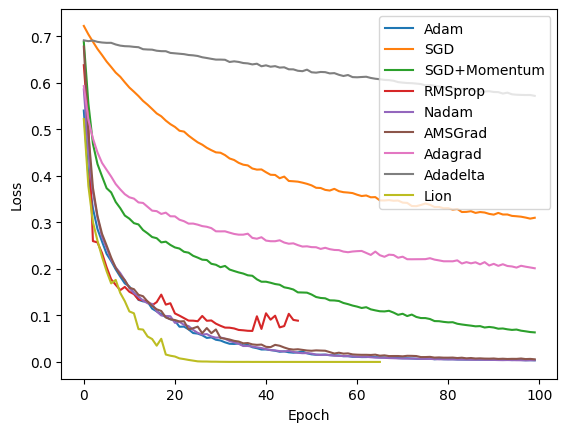

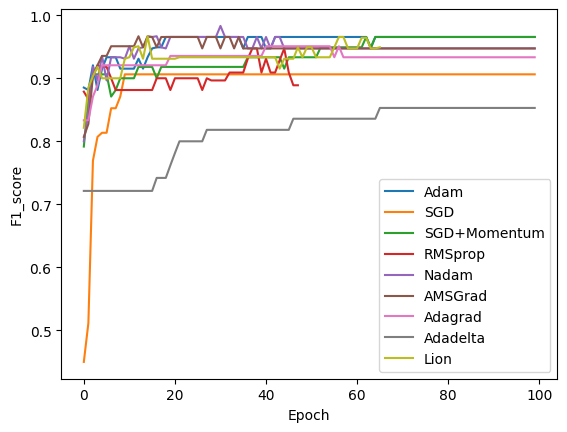

Adam         acc=0.9487  prec=0.9655  rec=0.9655  f1=0.9655  auc=0.9655  mcc=0.8655  time=3.1812s
SGD          acc=0.8462  prec=0.8286  rec=1.0000  f1=0.9062  auc=0.8828  mcc=0.5757  time=2.3883s
SGD+Momentum acc=0.9487  prec=0.9655  rec=0.9655  f1=0.9655  auc=0.9759  mcc=0.8655  time=3.0194s
RMSprop      acc=0.8462  prec=0.9600  rec=0.8276  f1=0.8889  auc=0.9466  mcc=0.6623  time=0.8912s
Nadam        acc=0.9231  prec=0.9643  rec=0.9310  f1=0.9474  auc=0.9793  mcc=0.8064  time=1.8059s
AMSGrad      acc=0.9231  prec=0.9643  rec=0.9310  f1=0.9474  auc=0.9793  mcc=0.8064  time=1.7899s
Adagrad      acc=0.8974  prec=0.9032  rec=0.9655  f1=0.9333  auc=0.9414  mcc=0.7197  time=1.5990s
Adadelta     acc=0.7436  prec=0.7436  rec=1.0000  f1=0.8529  auc=0.5241  mcc=0.0000  time=1.7941s
Lion         acc=0.9231  prec=0.9333  rec=0.9655  f1=0.9492  auc=0.9862  mcc=0.7934  time=1.0340s


In [ ]:
opt = ["Adam", "SGD", "Momentum", "RMSprop", "Nadam", "AMSGrad", "Adagrad", "Adadelta", "Lion"]

losses = []
times = []
f1_all = []

results = {
    "acc": [],
    "prec": [],
    "rec": [],
    "f1": [],
    "auc": [],
    "mcc": [],
    "epochs": []
}

for opt_name in opt:
    metrics, loss, elapsed_time, f1_scores = train_and_eval(
        opt_name=opt_name,
        Xtr=Xtr, Xte=Xte,
        ytr=ytr, yte=yte,
        hparams=hp
    )

    results["acc"].append(metrics["acc"])
    results["prec"].append(metrics["prec"])
    results["rec"].append(metrics["rec"])
    results["f1"].append(metrics["f1"])
    results["auc"].append(metrics["auc"])
    results["mcc"].append(metrics["mcc"])

    losses.append(loss)
    times.append(elapsed_time)
    f1_all.append(f1_scores)

# Plot losses
for i, opt_name in enumerate(opt):
    name = "SGD+Momentum" if opt_name == "Momentum" else opt_name
    plt.plot(losses[i], label=name)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Plot f1_scores
for i, opt_name in enumerate(opt):
    name = "SGD+Momentum" if opt_name == "Momentum" else opt_name
    plt.plot(f1_all[i], label=name)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("F1_score")
plt.show()

# Print results
for i, opt_name in enumerate(opt):
    name = "SGD+Momentum" if opt_name == "Momentum" else opt_name

    print(
        f"{name:12s} "
        f"acc={results['acc'][i]:.4f}  "
        f"prec={results['prec'][i]:.4f}  "
        f"rec={results['rec'][i]:.4f}  "
        f"f1={results['f1'][i]:.4f}  "
        f"auc={results['auc'][i]:.4f}  "
        f"mcc={results['mcc'][i]:.4f}  "
        f"time={times[i]:.4f}s"
    )

--------------------------------------------------------------------------------
#**Dimension Reduction Techniques**
--------------------------------------------------------------------------------

In [ ]:
def kmeans_features(X_train, X_test, n_clusters=8, random_state=42):
    # Ensure inputs are NumPy arrays for KMeans and subsequent NumPy operations
    if isinstance(X_train, torch.Tensor):
        X_train_np = X_train.numpy()
    else:
        X_train_np = X_train

    if isinstance(X_test, torch.Tensor):
        X_test_np = X_test.numpy()
    else:
        X_test_np = X_test

    kmeans = KMeans(n_clusters=n_clusters,
    n_init=10,
    random_state=random_state)
    kmeans.fit(X_train_np)

    def to_dist(X_arr):
        # X_arr will already be a NumPy array if the outer conversion happened
        return np.linalg.norm(
            X_arr[:, None, :] - kmeans.cluster_centers_[None, :, :],
            axis=2
            ).astype("float32")

    return to_dist(X_train_np), to_dist(X_test_np)

In [ ]:
n_clusters = 8
Xtr_km, Xte_km = kmeans_features(Xtr, Xte, n_clusters=n_clusters)

Xtr_km = torch.tensor(Xtr_km, dtype=torch.float32)
Xte_km = torch.tensor(Xte_km, dtype=torch.float32)

metrics, losses, elapsed_time, f1_scores = train_and_eval(opt_name="adam", Xtr=Xtr_km, Xte=Xte_km, ytr=ytr, yte=yte, hparams = hp, in_dim=n_clusters)
metrics

{'acc': 0.7692307692307693,
 'prec': 0.8125,
 'rec': 0.896551724137931,
 'f1': 0.8524590163934426,
 'auc': np.float64(0.8482758620689655),
 'mcc': np.float64(0.33742359105871017),
 'epochs': 38}

In [ ]:
def pca_features(X_train, X_test, var_threshold=0.95, random_state=42):
    # PCA
    pca = PCA(n_components=var_threshold, random_state=random_state)

    pca.fit(X_train)

    # Transformation train/test
    X_train_pca = pca.transform(X_train).astype("float32")
    X_test_pca = pca.transform(X_test).astype("float32")

    # Number of components
    n_components = pca.n_components_

    return X_train_pca, X_test_pca, n_components

In [ ]:
Xtr_pca, Xte_pca, n_components = pca_features(Xtr, Xte, var_threshold=0.95)

Xtr_pca = torch.tensor(Xtr_pca, dtype=torch.float32)
Xte_pca = torch.tensor(Xte_pca, dtype=torch.float32)

metrics, losses, elapsed_time, f1_scores = train_and_eval(opt_name="rmsprop", Xtr=Xtr_pca, Xte=Xte_pca, ytr=ytr, yte=yte, hparams=hp, in_dim=n_components)
print(metrics)
print(elapsed_time)

{'acc': 0.8717948717948718, 'prec': 0.9285714285714286, 'rec': 0.896551724137931, 'f1': 0.9122807017543859, 'auc': np.float64(0.9655172413793104), 'mcc': np.float64(0.6758915427189726), 'epochs': 100}
1.143038034439087


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=30, bottleneck_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

    def encode(self, x):
        """Returns the 8-D bottleneck representation."""
        return self.encoder(x)

In [ ]:
def autoencoder_features(X_train, X_test, epochs=50, lr=1e-3):
    input_dim = X_train.shape[1]
    bottleneck_dim = 8

    ae = Autoencoder(input_dim=input_dim, bottleneck_dim=bottleneck_dim)
    optimizer = optim.Adam(ae.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    Xtr_tensor = X_train.float()

    # Training loop
    for _ in range(epochs):
        optimizer.zero_grad()
        recon = ae(Xtr_tensor)
        loss = loss_fn(recon, Xtr_tensor)
        loss.backward()
        optimizer.step()

    # Extract 8-D features
    with torch.no_grad():
        Z_train = ae.encode(X_train.float())
        Z_test  = ae.encode(X_test.float())

    return Z_train, Z_test

In [ ]:
Xtr_ae, Xte_ae = autoencoder_features(Xtr, Xte, epochs=100, lr=1e-3)

metrics, losses, elapsed_time, f1_scores = train_and_eval(opt_name="rmsprop", Xtr=Xtr_pca, Xte=Xte_pca, ytr=ytr, yte=yte, hparams=hp, in_dim=8)
print(metrics)
print(elapsed_time)

{'acc': 0.8717948717948718, 'prec': 0.9, 'rec': 0.9310344827586207, 'f1': 0.9152542372881356, 'auc': np.float64(0.9155172413793102), 'mcc': np.float64(0.6539886462510549), 'epochs': 100}
1.0868303775787354


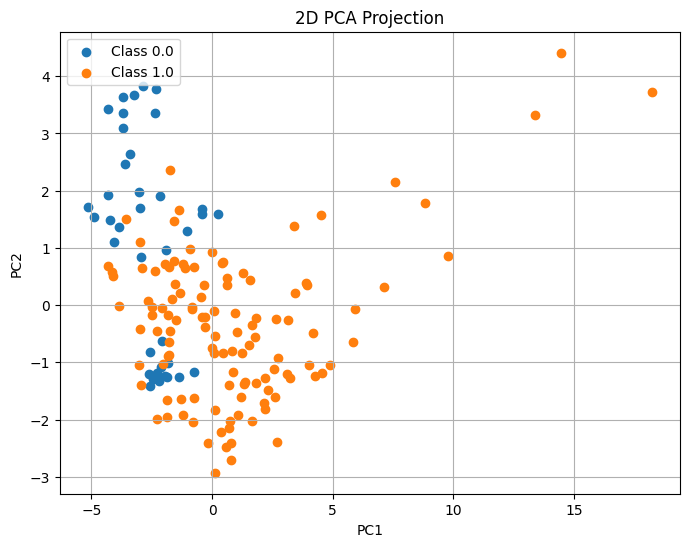

In [ ]:
from sklearn.decomposition import PCA
ytr_np = ytr.numpy().ravel()

# PCA 2D
pca_2d = PCA(n_components=2)
Xtr_pca_2d = pca_2d.fit_transform(Xtr_pca)  # Xtr should be NumPy

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(ytr_np):
    plt.scatter(Xtr_pca_2d[ytr_np == label, 0], Xtr_pca_2d[ytr_np == label, 1], label=f"Class {label}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection")
plt.legend()
plt.grid(True)
plt.show()

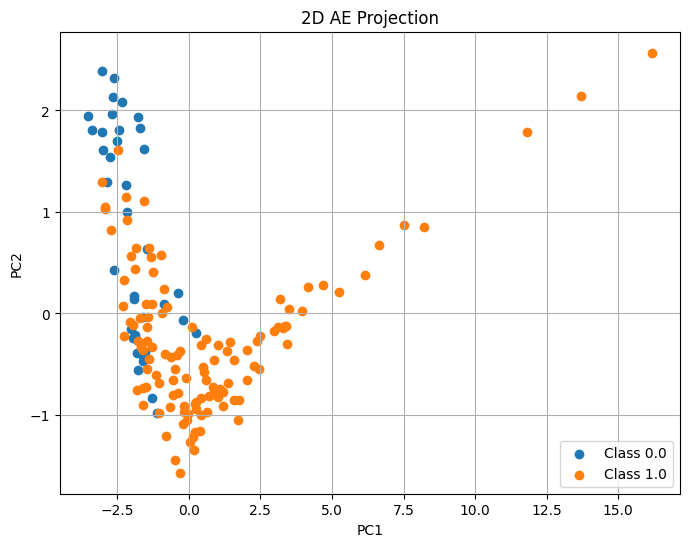

In [ ]:
ytr_np = ytr.numpy().ravel()

# PCA 2D
pca_2d = PCA(n_components=2)
Xtr_ae_2d = pca_2d.fit_transform(Xtr_ae)

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(ytr_np):
    plt.scatter(Xtr_ae_2d[ytr_np == label, 0], Xtr_ae_2d[ytr_np == label, 1], label=f"Class {label}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D AE Projection")
plt.legend()
plt.grid(True)
plt.show()

--------------------------------------------------------------------------------
#**Hyper-parameter** Analysis
--------------------------------------------------------------------------------

In [ ]:
search_space = {
    "lr": [1e-4, 1e-3, 1e-2, 1e-1],
    "momentum": [0.7, 0.8, 0.9, 0.99],
    "hidden_size": [8, 16, 32],
    "weight_decay": [0.001, 0.01],
    "batch_size": [16, 32, 64]
}

In [ ]:
def objective(opt_name, Xtr, Xte, ytr, yte, trial):
    hp = {
        "lr": trial.suggest_float("lr", 1e-4, 1e-1, log=True),
        "momentum": trial.suggest_float("momentum", 0.7, 0.99),
        "hidden_size": trial.suggest_categorical("hidden_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64])
    }

    metrics, losses, elapsed_time_val = train_and_eval(opt_name, Xtr, Xte, ytr, yte, hp)
    trial.set_user_attr("losses", losses)
    trial.set_user_attr("elapsed_time", elapsed_time_val)
    trial.set_user_attr("optimizer", opt_name)
    trial.set_user_attr("metrics", metrics)
    return metrics["f1"]

In [ ]:
# Optuna Grid Search
def run_optuna_grid_search(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=GridSampler(search_space=search_space)
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [ ]:
# Optuna Random Search
def run_optuna_random_search(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=RandomSampler()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [ ]:
# Bayesian Optimization
def run_bayesian_optimization(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler()
    )
    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [ ]:
# Hyperband / BOHB — Adaptive resource allocation.
def run_hyperband(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        pruner=HyperbandPruner()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [ ]:
# Evolutionary / Metaheuristic Search — GA, PSO, DE for AutoML.
def run_evolutionary(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=NSGAIISampler()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [ ]:
results = {}

# As for now testing the baseline with 'Adam' optimizer
adam_opt = "adam"

# Baselines
grid_hp, grid_f1, grid_traj, grid_perf, grid_loss, grid_met = run_optuna_grid_search(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Grid"] = grid_hp
results["Grid_f1"] = grid_f1
results["Grid_traj"] = grid_traj
results["Grid_perf"] = grid_perf
results["Grid_loss"] = grid_loss
results["Grid_met"] = grid_met

rand_hp, rand_f1, rand_traj, rand_perf, rand_loss, rand_met = run_optuna_random_search(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Random"] = rand_hp
results["Random_f1"] = rand_f1
results["Random_traj"] = rand_traj
results["Random_perf"] = rand_perf
results["Random_loss"] = rand_loss
results["Random_met"] = rand_met

# Advanced methods
bo_hp, bo_f1, bo_traj, bo_perf, bo_loss, bo_met = run_bayesian_optimization(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Bayes"] = bo_hp
results["Bayes_f1"] = bo_f1
results["Bayes_traj"] = bo_traj
results["Bayes_perf"] = bo_perf
results["Bayes_loss"] = bo_loss
results["Bayes_met"] = bo_met

hb_hp, hb_f1, hb_traj, hb_perf, hb_loss, hb_met = run_hyperband(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Hyperband"] = hb_hp
results["Hyperband_f1"] = hb_f1
results["Hyperband_traj"] = hb_traj
results["Hyperband_perf"] = hb_perf
results["Hyperband_loss"] = hb_loss
results["Hyperband_met"] = hb_met

ev_hp, ev_f1, ev_traj, ev_perf, ev_loss, ev_met = run_evolutionary(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Evolutionary"] = ev_hp
results["Evolutionary_f1"] = ev_f1
results["Evolutionary_traj"] = ev_traj
results["Evolutionary_perf"] = ev_perf
results["Evolutionary_loss"] = ev_loss
results["Evolutionary_met"] = ev_met

In [ ]:
# ------------------------------------------------------------------------------
# Truncate trajectories and performances for consistent plotting, as Optuna
# Grid Search runs all combinations while other methods are limited by
# n_trials (defaulting to 25).
# ------------------------------------------------------------------------------

N_TRIALS = 25

plt.figure(figsize=(10, 6))
plt.plot(results["Grid_traj"][:N_TRIALS], label="Grid Search")
plt.plot(results["Random_traj"][:N_TRIALS], label="Random Search")
plt.plot(results["Bayes_traj"][:N_TRIALS], label="Bayesian Opt (TPE)")
plt.plot(results["Hyperband_traj"][:N_TRIALS], label="Hyperband")
plt.plot(results["Evolutionary_traj"][:N_TRIALS], label="Evolutionary (NSGAII)")

plt.ylim([0.7, 1.0])
plt.xlabel("Trial")
plt.ylabel("Best F1")
plt.title("Performance Trajectory")
plt.legend()
plt.show()

# ------------------------------------------------------------------------------
# Changes to the evaluation class must be made if you want the 'elapsed_time'
# trajectories.
# For now 'grid_perf' returns only the best trial performance time.
# ------------------------------------------------------------------------------

# plt.figure(figsize=(10, 6))
# plt.plot(results["Grid_perf"][:N_TRIALS], label="Grid Search")
# plt.plot(results["Random_perf"][:N_TRIALS], label="Random Search")
# plt.plot(results["Bayes_perf"][:N_TRIALS], label="Bayesian Opt (TPE)")
# plt.plot(results["Hyperband_perf"][:N_TRIALS], label="Hyperband")
# plt.plot(results["Evolutionary_perf"][:N_TRIALS], label="Evolutionary (NSGAII)")

# plt.xlabel("Trial")
# plt.ylabel("Elapsed Time (s)")
# plt.title("Elapsed Time per Trial")
# plt.legend()
# plt.show()

In [ ]:
table = pd.DataFrame({
    "Method": ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"],
    "Best F1": [results["Grid_met"]["f1"], results["Random_met"]["f1"], results["Bayes_met"]["f1"], results["Hyperband_met"]["f1"], results["Evolutionary_met"]["f1"]],
    "Accuracy": [results["Grid_met"]["acc"], results["Random_met"]["acc"], results["Bayes_met"]["acc"], results["Hyperband_met"]["acc"], results["Evolutionary_met"]["acc"]],
    "Precision": [results["Grid_met"]["prec"], results["Random_met"]["prec"], results["Bayes_met"]["prec"], results["Hyperband_met"]["prec"], results["Evolutionary_met"]["prec"]],
    "Recall": [results["Grid_met"]["rec"], results["Random_met"]["rec"], results["Bayes_met"]["rec"], results["Hyperband_met"]["rec"], results["Evolutionary_met"]["rec"]],
    "AUC": [results["Grid_met"]["auc"], results["Random_met"]["auc"], results["Bayes_met"]["auc"], results["Hyperband_met"]["auc"], results["Evolutionary_met"]["auc"]],
    "Epochs":  [results["Grid_met"]["epochs"], results["Random_met"]["epochs"], results["Bayes_met"]["epochs"], results["Hyperband_met"]["epochs"], results["Evolutionary_met"]["epochs"]],
    "Ran-Time": [results["Grid_perf"], results["Random_perf"], results["Bayes_perf"], results["Hyperband_perf"], results["Evolutionary_perf"]],
    "Best Params": [
        results["Grid"], results["Random"], results["Bayes"], results["Hyperband"], results["Evolutionary"]
    ]

})

print(table)
table.to_latex(index=False)

--------------------------------------------------------------------------------
#**Everything together** - Reduction Techniques $\times$ Optimizers $\times$ Hyper-parameters
--------------------------------------------------------------------------------


In [ ]:
results = {}

opt = [
    "sgd",
    "momentum",
    "adam",
    "amsgrad",
    "adagrad",
    "adadelta",
    "nadam",
    "lion",
    "rmsprop"
]

features = {
    "raw": (Xtr, Xte),
    "kmeans": kmeans_features(Xtr, Xte, n_clusters=8),
    "pca": pca_features(Xtr, Xte, var_threshold=0.95)[:2],
    "autoencoder": autoencoder_features(Xtr, Xte, epochs=100, lr=1e-2)
}

# Convert all to tensors
for key, (Xtr_feat, Xte_feat) in features.items():
    features[key] = (torch.tensor(Xtr_feat, dtype=torch.float32),
                     torch.tensor(Xte_feat, dtype=torch.float32))

for feat_name, (Xtr_feat, Xte_feat) in features.items():
    results[feat_name] = {}

    for opt_name in opt:
        results[feat_name][opt_name] = {}  # Create sub-dict for each optimizer

        # Baselines
        grid_hp, grid_f1, grid_traj, grid_perf, grid_loss, grid_met = run_optuna_grid_search(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Grid"] = grid_hp
        results[feat_name][opt_name]["Grid_f1"] = grid_f1
        results[feat_name][opt_name]["Grid_traj"] = grid_traj
        results[feat_name][opt_name]["Grid_perf"] = grid_perf
        results[feat_name][opt_name]["Grid_loss"] = grid_loss
        results[feat_name][opt_name]["Grid_met"] = grid_met

        rand_hp, rand_f1, rand_traj, rand_perf, rand_loss, rand_met = run_optuna_random_search(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Random"] = rand_hp
        results[feat_name][opt_name]["Random_f1"] = rand_f1
        results[feat_name][opt_name]["Random_traj"] = rand_traj
        results[feat_name][opt_name]["Random_perf"] = rand_perf
        results[feat_name][opt_name]["Random_loss"] = rand_loss
        results[feat_name][opt_name]["Random_met"] = rand_met

        # Advanced methods
        bo_hp, bo_f1, bo_traj, bo_perf, bo_loss, bo_met = run_bayesian_optimization(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Bayes"] = bo_hp
        results[feat_name][opt_name]["Bayes_f1"] = bo_f1
        results[feat_name][opt_name]["Bayes_traj"] = bo_traj
        results[feat_name][opt_name]["Bayes_perf"] = bo_perf
        results[feat_name][opt_name]["Bayes_loss"] = bo_loss
        results[feat_name][opt_name]["Bayes_met"] = bo_met

        hb_hp, hb_f1, hb_traj, hb_perf, hb_loss, hb_met = run_hyperband(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Hyperband"] = hb_hp
        results[feat_name][opt_name]["Hyperband_f1"] = hb_f1
        results[feat_name][opt_name]["Hyperband_traj"] = hb_traj
        results[feat_name][opt_name]["Hyperband_perf"] = hb_perf
        results[feat_name][opt_name]["Hyperband_loss"] = hb_loss
        results[feat_name][opt_name]["Hyperband_met"] = hb_met

        ev_hp, ev_f1, ev_traj, ev_perf, ev_loss, ev_met = run_evolutionary(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Evolutionary"] = ev_hp
        results[feat_name][opt_name]["Evolutionary_f1"] = ev_f1
        results[feat_name][opt_name]["Evolutionary_traj"] = ev_traj
        results[feat_name][opt_name]["Evolutionary_perf"] = ev_perf
        results[feat_name][opt_name]["Evolutionary_loss"] = ev_loss
        results[feat_name][opt_name]["Evolutionary_met"] = ev_met

In [ ]:
features = ["raw", "kmeans", "pca", "autoencoder"]
optimizers = [
    "sgd",
    "momentum",
    "adam",
    "amsgrad",
    "adagrad",
    "adadelta",
    "nadam",
    "lion",
    "rmsprop"
]

hp_algos = ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"]
algos = ["Grid", "Random", "TPE", "Hyperband", "NSGAII"]

for feat in features:
    plt.figure(figsize=(16,10))
    for opt in optimizers:
        for i in range(len(hp_algos)):
            loss_curve = results[feat][opt][hp_algos[i] + "_loss"]
            label_name = f"{opt}+{algos[i]}"
            plt.plot(loss_curve, label=label_name)

    plt.ylim([0, 1])
    plt.title(f"Loss Curves per Epoch (Best Trial) for {feat.upper()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(fontsize=6, ncol=3)
    plt.grid(True)
    plt.show()

In [ ]:
def compact_params(hp_dict):
    # Convert long dict to short string, rounding floats
    if hp_dict is None:
        return ""
    return ", ".join(f"{k}={round(v, 4) if isinstance(v, float) else v}" for k, v in hp_dict.items())

rows = []

for feat_name, feat_dict in results.items():
    for opt_name, opt_dict in feat_dict.items():
        for algo in ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"]:
          time = opt_dict.get(f"{algo}_perf", None)
          met = opt_dict.get(f"{algo}_met", None)
          best_hp = opt_dict.get(algo, None)
          if met is not None:
              rows.append({
                  "Feature": feat_name,
                  "Optimizer": opt_name,
                  "HP Algorithm": algo,
                  "Accuracy": round(met.get("acc", 0), 4),
                  "Precision": round(met.get("prec", 0), 4),
                  "Recall": round(met.get("rec", 0), 4),
                  "F1": round(met.get("f1", 0), 4),
                  "AUC": round(met.get("auc", 0), 4),
                  "Epochs": met.get("epochs", 0),
                  "Run-Time": round(time, 4),
                  "Best Params": compact_params(best_hp)
                })

table_clean = pd.DataFrame(rows)

# Export to LaTeX
latex_code = table_clean.to_latex(index=False, longtable=True)
print(latex_code)

--------------------------------------------------------------------------------
#Best performing model + Hybrid (Fuzzy Rules and Bayesian)
## **PCA + RMSprop + Hyperband + Hybrid**
--------------------------------------------------------------------------------

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch Tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.values).float().ravel() # Extract values and flatten before converting to tensor

# Split data
Xtr, Xte, ytr, yte = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
Xtr_pca, Xte_pca, n_components = pca_features(Xtr, Xte, var_threshold=0.95)

Xtr_pca_tensor = torch.from_numpy(Xtr_pca).float()
Xte_pca_tensor = torch.from_numpy(Xte_pca).float()

Xtr_ae, Xte_ae = autoencoder_features(Xtr, Xte, epochs=100, lr=1e-3)

In [ ]:
import skfuzzy as fuzz

def fuzzy_score(X, alpha1=0.5, beta1=0.5, alpha2=0.5, beta2=1.5, rho=2.0):
    """
    Compute fuzzy membership scores for selected features.
    The example features (0 and 5) correspond to 'MDVP:Fo(Hz)' and 'MDVP:Shimmer'
    in the Parkinson's dataset (after dropping 'name' and 'status').
    """
    X_np = X.numpy()
    f1 = X_np[:, 0]  # MDVP:Fo(Hz) - mean fundamental frequency
    f2 = X_np[:, 5]  # MDVP:Shimmer - local shimmer variability

    # Simplified High-Risk Membership for scaled data (~1 to 2 standard deviations above mean)
    mu_high_f1 = 1 / (1 + np.exp(-alpha1 * (f1 - beta1))) # Higher f1 -> higher membership
    mu_high_f2 = 1 / (1 + np.exp(-alpha2 * (f2 - beta2))) # Higher f2 -> higher membership

    # Weighted sum as fuzzy score (Higher R implies higher risk)
    R = rho * mu_high_f1 + (1.0 - rho) * mu_high_f2

    # Ensure R is between 0 and 1
    R = np.clip(R, 0, 1)
    return torch.tensor(R, dtype=torch.float32)


# ------------------------------
# 4. Rule-Based Overrides
# ------------------------------
def rule_override(p, X, k=1.0, base=0.7, scale=0.3):
    """
    Soft rule-based override for probabilities based on critical feature patterns.
    Instead of hard 0.9, use a sigmoidal scaling based on extremeness of features.

    Parameters:
        p (torch.Tensor): Original probabilities (batch_size,)
        X (torch.Tensor): Input features (batch_size, n_features)
        k (float): Sigmoid slope controlling how fast p approaches max
        base (float): Base probability for borderline cases
        scale (float): Maximum additional probability added for extreme cases
    Returns:
        torch.Tensor: Updated probabilities
    """
    p_new = p.clone()

    # Critical features
    f1 = X[:, 0]  # MDVP:Fo(Hz)
    f2 = X[:, 16] # HNR

    # Calculate "extremeness" as sum of standardized deviations below -1
    extremeness = torch.clamp((-f1 - 1) + (-f2 - 1), min=0)

    # Apply sigmoid to map extremeness to [0,1]
    adjustment = scale * torch.sigmoid(k * extremeness)

    # Apply soft override
    critical_mask = (f1 < -1) & (f2 < -1)
    p_new[critical_mask] = torch.clamp(base + adjustment[critical_mask], max=1.0)

    return p_new


# ------------------------------
# 5. Bayesian Posterior Update
# ------------------------------
def bayesian_update(p_likelihood, prior=0.7):
    """
    Compute posterior probability using Bayes theorem (P(D|E)).
    D = Disease (Parkinson's), E = Evidence (Hybrid MLP/Fuzzy Score)
    p_likelihood is P(E|D) if we assume the score represents the likelihood of the evidence E
    given the disease D, but in classification, it's usually P(D|E).

    The formula used in the code is for P(D|E) where E is the likelihood score itself:
    P(D|E) = (P(E|D) * P(D)) / (P(E|D)*P(D) + P(E|~D)*P(~D))"""

    P_E_given_D = p_likelihood # Simplified
    P_E_given_notD = 1 - p_likelihood # Simplified

    # Prior probability of having the condition (Parkinson's) - P(D)
    P_D = prior
    # Prior probability of not having the condition - P(~D)
    P_notD = 1 - prior

    # Bayes' Theorem for Posterior P(D|E)
    numerator = P_E_given_D * P_D
    denominator = numerator + P_E_given_notD * P_notD + 1e-8

    posterior = numerator / denominator
    return posterior

# ------------------------------
# 6. Train & Evaluate Hybrid MLP
# ------------------------------
def train_and_eval_hybrid(opt_name, Xtr, Xte, Xtr_orig, Xte_orig, ytr, yte, is_hybrid, hparams, in_dim=Xtr.shape[1]):
    start_time = time.time()

    # Ensure yte is integer for metrics where needed
    yte_int = yte.int().numpy()

    model = MLP(in_dim=in_dim, hidden=hparams["hidden_size"])
    optimizer = get_optimizer(opt_name, model.parameters(), lr=hparams["lr"], momentum=hparams["momentum"], weight_decay=hparams["weight_decay"])
    criterion = nn.BCELoss() # Binary Cross Entropy Loss

    train_loader = DataLoader(
        TensorDataset(Xtr, ytr),
        batch_size=hparams["batch_size"],
        shuffle=True
    )

    for epoch in range(hparams["epochs"]):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb).squeeze()
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

    # ---------- Hybrid Reasoning Layer ----------
    model.eval()
    with torch.no_grad():
        # Base MLP probability
        p = model(Xte).squeeze()  # P_MLP
        p_current = p

        # Step 11: Fuzzy scoring
        if is_hybrid[0]:
            R = fuzzy_score(
                Xte_orig,
                hparams["alpha1"], hparams["beta1"],
                hparams["alpha2"], hparams["beta2"],
                hparams["rho"]
            )
            p_current = hparams["mlp_weight"] * p_current + (1.0 - hparams["mlp_weight"]) * R

        # Step 12: Rule-based override
        if is_hybrid[1]:
            p_current = rule_override(
                p_current,
                Xte_orig,
                hparams["k"],
                hparams["base"],
                hparams["scale"]
            )

        # Step 13: Bayesian update
        if is_hybrid[2]:
            p_current = bayesian_update(p_current, prior=hparams["prior"])

    # Final prediction
    y_pred = (p_current >= 0.5).int().numpy()

    end_time = time.time()
    duration = end_time - start_time

    metrics = {
            "acc": accuracy_score(yte_int, y_pred),
            "prec": precision_score(yte_int, y_pred, zero_division=0),
            "rec": recall_score(yte_int, y_pred, zero_division=0),
            "f1": f1_score(yte_int, y_pred, zero_division=0),
            "auc": roc_auc_score(yte_int, p_current.numpy()), # Use p_current for AUC as it's the final probability
            "mcc": matthews_corrcoef(yte_int, y_pred),
            "time": duration
        }

    return metrics

In [ ]:
def objective_hybrid(opt_name, Xtr, Xte, Xtr_or, Xte_or, ytr, yte, is_hybrid, in_dim, trial):
    hp = {
        "lr": trial.suggest_float("lr", 1e-4, 1e-1, log=True),
        "momentum": trial.suggest_float("momentum", 0.7, 0.99),
        "hidden_size": trial.suggest_categorical("hidden_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
        "mlp_weight": trial.suggest_float("mlp_weight", 0.1, 0.9),
        "alpha1": trial.suggest_int("alpha1", 1, 10),
        "beta1": trial.suggest_float("beta1", 0.5, 2.0),
        "alpha2": trial.suggest_int("alpha2", 1, 10),
        "beta2": trial.suggest_float("beta2", 0.5, 2.0),
        "rho": trial.suggest_float("rho", 0.01, 1.0),
        "prior": ytr.float().mean().item(),
        "k": trial.suggest_float("k", 0.5, 5.0),
        "base": trial.suggest_float("base", 0.01, 1.0),
        "scale": trial.suggest_float("scale", 0.01, 1.0),
        "epochs": 100
    }

    metrics = train_and_eval_hybrid(opt_name, Xtr, Xte, Xtr_or, Xte_or, ytr, yte, is_hybrid, hp, in_dim)

    trial.set_user_attr("metrics", metrics)
    trial.set_user_attr("elapsed_time", metrics["time"])

    return metrics["f1"]

In [ ]:
study_hybrid = optuna.create_study(
        direction="maximize",
        pruner=HyperbandPruner()
    )

results = {
    "acc" : [],
    "prec" : [],
    "rec" : [],
    "f1" : [],
    "auc" : [],
    "mcc" : [],
    "time" : []
}

is_hybrid = [True, True, True]
for _ in range(5):
    study_hybrid.optimize(lambda trial: objective_hybrid("rmsprop", Xtr_pca_tensor, Xte_pca_tensor, Xtr, Xte, ytr, yte, is_hybrid, n_components, trial), n_trials=10) # Fuzzy, Rule, Bayesian
    # study_hybrid.optimize(lambda trial: objective_hybrid("adam", Xtr, Xte, Xtr, Xte, ytr, yte, is_hybrid, Xtr.shape[1], trial), n_trials=10)
    #study_hybrid.optimize(lambda trial: objective_hybrid("RMSprop", Xtr_ae, Xte_ae, Xtr, Xte, ytr, yte, is_hybrid, 8, trial), n_trials=10)

    print("Number of finished trials: ", len(study_hybrid.trials))
    print("Best trial:")

    trial_hybrid = study_hybrid.best_trial

    print("  Value (F1): ", trial_hybrid.value)
    print("  Params: ")
    for key, value in trial_hybrid.params.items():
        print(f"    {key}: {value}")

    print("  Metrics (Best Trial):")
    best_hybrid_metrics = trial_hybrid.user_attrs['metrics']
    for key, value in best_hybrid_metrics.items():
        results[key].append(value)
        print(f"    {key}: {value}")

In [ ]:
print(f"{np.mean(results["acc"]):.4f}, {np.std(results["acc"]):.4f}")
print(f"{np.mean(results["prec"]):.4f}, {np.std(results["prec"]):.4f}")
print(f"{np.mean(results["rec"]):.4f}, {np.std(results["rec"]):.4f}")
print(f"{np.mean(results["f1"]):.4f}, {np.std(results["f1"]):.4f}")
print(f"{np.mean(results["auc"]):.4f}, {np.std(results["auc"]):.4f}")
print(f"{np.mean(results["mcc"]):.4f}, {np.std(results["mcc"]):.4f}")